In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils, visualize_utils
from utils.training_utils import train_model, test_model
from models.spectra_net import SpectraNet
import Simple_RCWA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [2]:
pi = np.pi

# ====== Unit Define ======
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ====== Constant Define ======
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Initialize basic structure params

Initialize params that will be shared in both the target and the sampled data.

In [3]:
# ====== Material property definitions ======
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
# truncate freq over 1.7THz
freq_truncate = [-1, 1.7]  # in THz
freq_step = 4

freq, eps_absorber = Simple_RCWA.utils.data_utils.truncate_freq(eps_absorber_file, freq_range=freq_truncate, freq_step=freq_step)
params_eps = [eps_absorber]


# ====== Structure params definitions ======
Lx = 160 * micrometres  # period along x
Ly = 160 * micrometres  # period along y
d1 = 75 * micrometres  # thickness of layer 1
params_geometry = [Lx, Ly, [d1]]

params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
list_layer_funcs = [Simple_RCWA.utils.rcwa_utils.layerfunc_absorber_ellipse_hole]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'

print('freq.shape:', freq.shape)
print('freq.min (THz):', freq.min()/1e12)
print('freq.max (THz):', freq.max()/1e12)

Freq truncated.
freq.shape: (222,)
freq.min (THz): 0.5
freq.max (THz): 1.696696639


# Initialize and visualize the target spectra

Set a target pattern to search.

The target spectra can be any form, does not need to come from a spectra, this is just for convenience.

Calculation Progress: 100%
freq.shape: (222,)
R_total.shape: (222,)
T_total.shape: (222,)


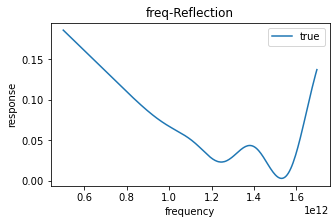

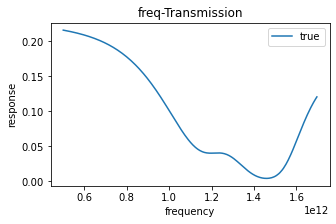

In [4]:
'''
Ellipse hole absorber.
'''
# ====== Material structure define ======
D1 = 150. * micrometres  # two axes of the ellipse hole
D2 = 130. * micrometres
list_layer_params = [[D1, D2]]


# ====== RCWA solver ======
Si_square_hole = Simple_RCWA.utils.rcwa_utils.Material(freq, params_eps, params_geometry, params_mesh, PQ_order,
                                     list_layer_funcs, list_layer_params, source, device_rcwa)
R_total, T_total = Si_square_hole.rcwa_solve()

print('freq.shape:', freq.shape)
print('R_total.shape:', R_total.shape)
print('T_total.shape:', T_total.shape)
R_target = R_total
T_target = T_total

size_fig = (5,3)
plt.figure(1, figsize=size_fig)
plt.plot(freq, R_target, label='true')
plt.title('freq-Reflection')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('response')

plt.figure(2, figsize=size_fig)
plt.plot(freq, T_target, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('response')

plt.show()

# Design to learn to design

## Initialization

In [5]:
loss_tolerance = 1e-5
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training
path_material_name = 'absorber'


# ====== RCWA simulation prepare ======
# make data dir if necessary
# dir for all intermediate data
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')
# dir for trained models
if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')


# ====== Params range, [D1, D2] ======
D1_range = np.arange(50,151,1)
D2_range = np.arange(50,151,1)
params_range = [D1_range, D2_range]


# ====== RCWA solver setting ======
'''
solver setting should not being changed while sampling and training!
[freq, params_eps, params_geometry, params_mesh, PQ_order, list_layer_funcs, source, device]
'''
solver_setting = [freq, params_eps, params_geometry, params_mesh, PQ_order, list_layer_funcs, source, device_rcwa]


# ====== Generate pseudo params, [D1, D2] ======
range_D1 = [50,151,1]  # [range_start, range_end, step_size]
range_D2 = [50,151,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
pseudo_params = pseudo_params_D1_D2  # [D1,D2]


# ====== Define target spectra ======
# tg_idx_freq_R = np.array([129])
# tg_value_R = np.array([0.03])
# tg_idx_freq_T = np.array([0, 167])
# tg_value_T = np.array([0.228, 0.004])
tg_idx_freq_R = np.array(np.arange(222))
tg_value_R = R_target
tg_idx_freq_T = np.array(np.arange(222))
tg_value_T = T_target
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


# ====== Initiate intermediate params ======
'''
The params below will be updated among rounds while running.
'''
params_list = np.array([]).reshape((0, len(params_range)))  # initiate params list
params_all = np.array([]).reshape((0, len(params_range)))  # [0, N_params]
R_all = np.array([]).reshape((0, freq.shape[0]))  # [0, N_freq]
T_all = np.array([]).reshape((0, freq.shape[0]))


# ====== Initiate the network ======
dim_in = len(params_range)  # N_params
dim_out = freq.shape[0]  # N_freq
net = SpectraNet(dim_in,dim_out)
net = net.to(device)


# ======Initiate training settings ======
BTSZ = 20  # batch size
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
criteon = nn.MSELoss()
N_epoch = 2000  # number of epochs trained
early_stop_parser=[True, 1000, 100]  # [use_early_stop, num_epoch_force, num_epoch_tolerance]

## Loop to add more sampling data and train the design network

**************************** ROUND 1 ****************************
====== Generate data for training ======
N_possible: [101, 101] , 10201 in total
N_needed: 5
Sample points number available, continue calculating...
----------------
[ 1 / 5 ] [D1, D2] = [130 144]
Calculation Progress: 100%
----------------
[ 2 / 5 ] [D1, D2] = [89 57]
Calculation Progress: 100%
----------------
[ 3 / 5 ] [D1, D2] = [126  62]
Calculation Progress: 100%
----------------
[ 4 / 5 ] [D1, D2] = [130 135]
Calculation Progress: 100%
----------------
[ 5 / 5 ] [D1, D2] = [63 84]
Calculation Progress: 100%
* Round sampled data saved.
params_all.shape: (5, 2)
R_all.shape: (5, 222)
T_all.shape: (5, 222)
* All rounds data saved.
LEN dataloader_train: 1
LEN dataloader_test: 1
====== Train network ======
### EPOCH [1081/2000] || TEST LOSS: 1.102021E-09
* FINAL TRAIN LOSS: 6.875898905800426e-10
* FINAL TEST LOSS 1.1020212520307382e-09
====== Spectra search ======
# search both R and T
pseudo_params.shape: (10201, 2)
pa

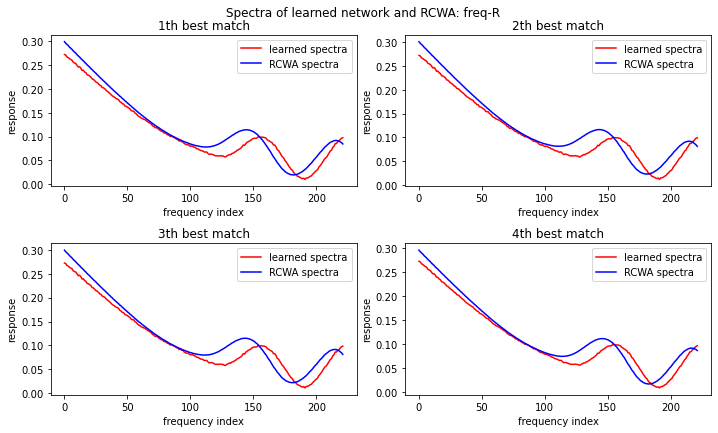

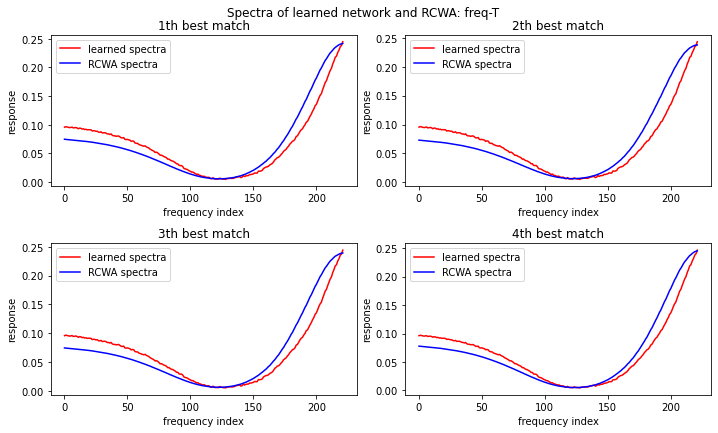

* Model saved.
**************************** ROUND 2 ****************************
====== Generate data for training ======
N_possible: [101, 101] , 10201 in total
N_needed: 10
Sample points number available, continue calculating...
----------------
[ 1 / 5 ] [D1, D2] = [58 58]
Calculation Progress: 100%
----------------
[ 2 / 5 ] [D1, D2] = [142  87]
Calculation Progress: 64%

In [ ]:
plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate sampled data from RCWA solver ======
    print('====== Generate data for training ======')
    num_data = 5

    params, R, T, params_list = data_utils.generate_data_absorber(num_data,
                                                                  params_range,
                                                                  solver_setting_list=solver_setting,
                                                                  params_list=params_list,
                                                                  use_log=True,
                                                                  flag_spectra_search_rerun=False)
    
    # save round sampled data
    path_sampled_data_round = './data/' + path_material_name + '/sampled_data_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_sampled_data_round, params=params, R=R, T=T)
    print('* Round sampled data saved.')
    
    # update the training data with new sampled data
    params_all = np.concatenate((params_all, params), axis=0)
    R_all = np.concatenate((R_all, R), axis=0)
    T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)  # [N,N_params]
    print('R_all.shape:', R_all.shape)  # [N,N_freq]
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('* All rounds data saved.')
    
    
    # ====== Train the network with sampled data from RCWA ======
    # prepare the dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # train the network
    print('====== Train network ======')
    loss_train, loss_test, net = training_utils.train_model(dataloader, 
                                                            dataloader_test, 
                                                            optimizer, 
                                                            criteon, 
                                                            net, 
                                                            device, 
                                                            NUM_EPOCH=N_epoch, 
                                                            early_stop_parser=early_stop_parser)
    print('* FINAL TRAIN LOSS:', loss_train)
    print('* FINAL TEST LOSS', loss_test)
    
    # visualize spectra on the test set
#     visualize_utils.visualize_trained_net(dataloader_test, net, device)
    
    
    # ====== Spectra search ======
    print('====== Spectra search ======')
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, 
                                                                          net, 
                                                                          device, 
                                                                          PATH_pseudo_dataset='', 
                                                                          flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('pseudo_params.shape:', pseudo_params.shape)
    print('params_pick.shape:', params_pick.shape)
    print('R_pick & T_pick.shape:', R_pick.shape)
    print('params_pick:', params_pick)
    # visualize spectra search results
#     visualize_utils.visualize_spectra_search(params_pick, R_pick, T_pick)
    # save picked design params for visualization (*optional)
    path_params_pick_visual = './data/' + path_material_name + '/params_pick_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_params_pick_visual, params=params_pick)
    print('* Picked params from spectra search saved.')


    # ====== Add picked samples to the training set with a probability (annealing) ======
    print('====== Add searched params into the training set ======')
    if ROUND==1:
        p_no_add = 1
        beta = 0.8
    else:
        p_no_add *= beta
    print('ROUND %d || annealing probability p_no_add: %f' %(ROUND, p_no_add))
    R_simu, T_simu = np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(params_pick.shape[0]):  # for each picked sample points
        # run RCWA to get simulated results
        print('Calling RCWA to slove the [%d / %d] th picked params.' % (idx_pick+1, params_pick.shape[0]))
        params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
        rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data,
                                                                               params_range,
                                                                               solver_setting_list=solver_setting,
                                                                               params_list=params_list,
                                                                               use_log=True,
                                                                               flag_spectra_search_rerun=True,
                                                                               rerun_params=params_pick_rcwa)
        R_simu[idx_pick], T_simu[idx_pick] = R_simu_i, T_simu_i
        if np.random.random_sample()>p_no_add:  # add picked sample to training set
            if np.any(np.all(params_all-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the training set
                print('Picked sample already in the training set.')
            else:
                print('Add picked sample to the training set.')
                params_all = np.concatenate((params_all, rerun_params_i), axis=0)
                R_all = np.concatenate((R_all, R_simu_i), axis=0)
                T_all = np.concatenate((T_all, T_simu_i), axis=0)
        else:
            print('Picked sample not added.')
        print('------------')
    # update params_list
    params_list = params_all
    path_params_list = './data/' + path_material_name + '/params_list.npz'
    np.savez(path_params_list, params_list=params_all)
    # save round all data + added picked data
    path_all_data_round = './data/' + path_material_name + '/all_data_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params_all, R=R_all, T=T_all)
    print('* All rounds data saved.')
    
    
    # ====== MSE between learned spectra and simulated spectra ======
    print('====== Loss between learned spectra and simulated spectra ======')
    mse_R = ((R_pick - R_simu)**2).mean(axis=-1)  # [N_top]
    mse_T = ((T_pick - T_simu)**2).mean(axis=-1)
    mse = (mse_R + mse_T) / 2
    print('* MSE_R for each:', mse_R)
    print('* MSE_T for each:', mse_T)
    print('* MSE (averaged on R&T) for each:', mse)
    loss = np.average(mse)  # avg loss among all picked params for both R&T should be small enough
    print('* CURRENT ROUND LOSS:', loss)

    # visualize learned spectra and RCWA true spectra
    visualize_utils.visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(10,6))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    PATH_MODEL = './trained_models/' + path_material_name + '/SpectraNet_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net.state_dict(), PATH_MODEL)
    print('* Model saved.')
    
    ROUND += 1
    
plt.ioff()

## Save the trained model

In [ ]:
PATH_MODEL = './trained_models/' + path_material_name + '/SpectraNet_final.pt'
torch.save(net.state_dict(), PATH_MODEL)
print('Model saved.')